In [1]:
# import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
import pickle
from scipy import stats
import time


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


random.seed(123)
np.random.seed(123)

In [2]:
n_trials = 10 #

n_trajectories = 1000

bootstrap = 0

threshold1 = 200 # 
threshold2 = 0.8 # 
threshold3 = 0.6 # try with 0.9 or 1.0 / myopic and non-myopic S1
threshold4 = 200 # 
threshold5 = 0 # 
threshold7 = 0.5 # 

df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df7 = pd.DataFrame()

In [3]:
def compute_mean(target = None):

    df = pd.DataFrame()

    if target: 

        for i in range(0, len(target.time_stat)):
            #print(f"Stat: {mca.trajectory_stat[i]}")
            mask_1 = np.array(target.trajectory_stat[i]) == 1
            mask_2 = np.array(target.trajectory_stat[i]) == 0
            
            #Creaty np array from time array
            selected = np.array(target.time_stat[i])
            #Select actions in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            time_s1 = np.sum(selected_1)
            time_s2 = np.sum(selected_2)
            
            #Creaty np array from trajectory array
            selected = np.array(target.trajectory_stat[i])
            #Select builder in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            usage_s1 = np.sum(selected_1)
            usage_s2 = len(target.trajectory_stat[i]) - np.sum(selected_1)
            
            #Creaty np array from trajectory array
            selected = np.array(target.action_reward[i])
            #Select builder in trajectory based on which system computed them
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #Compute total time per solver
            reward_s1 = np.sum(selected_1)
            reward_s2 = np.sum(selected_2)
            

            dict_mca = {}
            dict_mca['traj_n'] = i
            dict_mca['length'] = len(target.trajectory_stat[i])
            dict_mca['reward'] = np.sum(target.action_reward[i])
            dict_mca['time'] = np.sum(target.time_stat[i])
            
            dict_mca['sub_type'] = "s1"
            dict_mca['time_agent'] = time_s1
            dict_mca['avg_time'] = time_s1 / usage_s1
            dict_mca['reward_agent'] = reward_s1
            dict_mca['avg_reward'] = reward_s1 / usage_s1
            dict_mca['usage']= usage_s1
            dict_mca['perc_usage']= usage_s1 / len(target.trajectory_stat[i])
            temp_df = pd.DataFrame(data=dict_mca, index=[i])
            df = pd.concat([df, temp_df])
            
            
            dict_mca = {}
            dict_mca['traj_n'] = i
            dict_mca['length'] = len(target.trajectory_stat[i])
            dict_mca['reward'] = np.sum(target.action_reward[i])
            dict_mca['time'] = np.sum(target.time_stat[i])
            
            dict_mca['sub_type'] = "s2"
            dict_mca['time_agent'] = time_s2
            dict_mca['avg_time'] = time_s2 / usage_s2
            dict_mca['reward_agent'] = reward_s2
            dict_mca['avg_reward'] = reward_s2 / usage_s2
            dict_mca['usage']= usage_s2
            dict_mca['perc_usage']= usage_s2 / len(target.trajectory_stat[i])
            
            temp_df = pd.DataFrame(data=dict_mca, index=[i])
            df = pd.concat([df, temp_df])
            
    else:
        dict_mca = {}
        dict_mca['traj_n'] = 0
        dict_mca['length'] = 0
        dict_mca['reward'] = 0
        dict_mca['time'] = 0

        dict_mca['sub_type'] = "null"
        dict_mca['time_agent'] = 0
        dict_mca['avg_time'] = 0 
        dict_mca['reward_agent'] = 0
        dict_mca['avg_reward'] = 0 
        dict_mca['usage']= 0
            
        temp_df = pd.DataFrame(data=dict_mca, index=[0])
        df = pd.concat([df, temp_df])

    
    #print(dict_mca)
    
    return df

In [4]:
def plot_results(df, x, y, min_label, max_label, bootstrap = bootstrap):
    
    #print(df)

    '''#print(f"RL\t -> Length: {np.mean(df.loc[(df['type']=='const')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='const')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='const')]['Viol'].values)}")    
    print_results(df.loc[(df['type']=='const')], 'RL')
    print_results(df.loc[(df['type']=='10')& (df['traj_n']>=bootstrap)& (df['t4']==0)], 'MCA_10')
    print_results(df.loc[(df['type']=='01')& (df['traj_n']>=bootstrap)& (df['t4']==0)], 'MCA_01')
    print_results(df.loc[(df['type']=='02')& (df['traj_n']>=bootstrap)& (df['t4']==0)], 'MCA_55')
    print_results(df.loc[(df['type']=='s1')& (df['traj_n']>=bootstrap)], 'MCA_s1')
    #print_results(df.loc[(df['type']=='s1_nb') & (df['t1']==200)], 'MCA_nb')
    print_results(df.loc[(df['type']=='s2')& (df['traj_n']>=bootstrap)], 'MCA_s2')'''
    
    '''print(f"MCA 10\t -> Length: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Viol'].values)}")
    print(f"MCA 01\t -> Length: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Viol'].values)}")
    print(f"MCA 55\t -> Length: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Viol'].values)}")
    print(f"Only S1\t -> Length: {np.mean(df.loc[(df['type']=='s1')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='s1')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='s1')]['Viol'].values)}")
    print(f"Only S2\t -> Length: {np.mean(df.loc[(df['type']=='s2')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='s2')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='s2')]['Viol'].values)}")'''
    
    fig=plt.figure(figsize=(12, 7))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    temp_df = df.loc[(df['type']!="mixed") & (df['type']!="s1_nb")&(df['type']!="const")&(df['type']!="nominal")& (df['type']!="s1") & (df['type']!="s2")& (df['traj_n']>=bootstrap)]
    print("Prima")
    #g=sns.lineplot(x=x, y=y, data=df, hue="type",markers=True, dashes=False)
    g = sns.barplot(x=x, y=y, hue="type", data=temp_df, palette="autumn", ci=95);
    print("Dopo")
    #g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])
    
    constrained_line = np.mean(df.loc[(df['type']=="const")][y])
    nominal_line = np.mean(df.loc[(df['type']=="nominal")][y])
    print(f"constrained_line: {constrained_line} {y}")
    print(f"nominal_line: {nominal_line} {y}")
    #s1_line = np.mean(df.loc[(df['type']=="s1")& (df['traj_n']>=bootstrap)][y])
    s2_line = np.mean(df.loc[(df['type']=="s2")& (df['traj_n']>=0)][y])
    #mixed_line = np.median(temp_df.loc[(temp_df['type']=="mixed")& (temp_df['traj_n']>=bootstrap)][y])
    s1nb_line = np.mean(df.loc[(df['type']=="s1_nb")& (df['traj_n']>=0)][y])
    
    print(f"s2: {s2_line} s1:{s1nb_line}")
    
    g.axhline(constrained_line, color='r', linestyle='--', label="RL Constrained")
    g.axhline(nominal_line, color='b', linestyle='--', label="RL Nominal")
    #g.axhline(s1_line, color='b', linestyle='--', label="S1")
    #g.axhline(mixed_line, color='g', linestyle='--', label="Mixed")
    g.axhline(s1nb_line, color='b', linestyle='-.', label="S1")
    g.axhline(s2_line, color='g', linestyle='-.', label="S2")
    #g.set_ylim([min_label, max_label])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(label=y+" varying "+x)
    
    '''h, l = g.get_legend_handles_labels()
    labels=["S1", "S2","SOFAI 10","SOFAI 01","SOFAI 02"]
    g.legend(h, labels)'''
    plt.legend()
    plt.grid(alpha=0.3)
    #g.set_xticks(range(11)) # <--- set the ticks first

    #plt.xlabel("W(Nominal, Constraints)")
    #plt.ylabel("Avg JS dist")
    plt.show()
    #fig.savefig(os.path.join("./", f"{y}_varying_{x}.png"), bbox_inches = 'tight')
    fig.savefig(os.path.join("./", f"{y}_risk_{threshold3}.png"), bbox_inches = 'tight')

In [5]:
from mc.self import *
from mc.system1 import *
from mc.system2 import *
from mc.mca import *

def build_dict(temp_matrix, type_mca, agent=None, s1_usage=0,  t1=200, t2=0.8, t3=0, t4=0, t6=1, t7=0.5, bootstrap=0):
    '''temp_dict={}
    temp_dict['type']= type_mca
    temp_dict['Length']= temp_matrix[1]
    temp_dict['Reward']= temp_matrix[2]
    temp_dict['Viol'] = temp_matrix[4]
    temp_dict['S1_Usage'] = s1_usage
    temp_dict['t1'] = t1
    temp_dict['t2'] = t2
    temp_dict['t3'] = t3
    temp_dict['t4'] = t4
    temp_dict['t6'] = t6
    temp_dict['t7'] = t7
    temp_df = pd.DataFrame(data=temp_dict, index=[0])'''
    
    temp_df = compute_mean(agent)
    temp_df['type']= type_mca
    temp_df['Length']= temp_matrix[1]
    if agent == None: temp_df['length']= temp_matrix[1]
    temp_df['Reward']= temp_matrix[2]
    if agent == None: temp_df['reward']= temp_matrix[2]
    temp_df['Viol'] = temp_matrix[4]
    temp_df['S1_Usage'] = s1_usage
    temp_df['t1'] = t1
    temp_df['t2'] = t2
    temp_df['t3'] = t3
    temp_df['t4'] = t4
    temp_df['t6'] = t6
    temp_df['t7'] = t7
    
    return temp_df
    

def simulation(n_cfg, c_cfg, demo, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories=200, 
               threshold1 = 200, threshold2 = 0.8, threshold3 = 0.4, 
               threshold4 = 0, threshold6 = 1, threshold7 = 0.5, df=None, jsdiv =None, bootstrap = 0):
    
    if df is None:
        df = pd.DataFrame()
        
    if jsdiv is None:
        jsdiv = pd.DataFrame()
   
    n=n_cfg.mdp
    c=c_cfg.mdp
    
    '''temp_matrix = count_states(demo.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='const')
    df = pd.concat([df, temp_dict])

    #mca_s1 = MCA(n=n, c=c, demo=demo, only_s1=True)
    #demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1 = count_states(demo_mca_s1.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1, type_mca='s1', agent=mca_s1, s1_usage=mca_s1.getStatistics()[0])
    df = pd.concat([df, temp_dict])

    #mca_s2 = MCA(n=n, c=c, demo=demo, only_s2=True)
    #demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s2, type_mca='s2', agent=mca_s2 )
    df = pd.concat([df, temp_dict])'''
    
    #for t3 in threshold3:
    #    for t4 in threshold4:
    #print(f"t1:{t1} t2:{t2} t3:{t3} t4:{t4} t6:{t6} t7:{t7} ")

    mca_10 = MCA(n=n, c=c, demo=None, threshold1 = threshold1,  threshold3 = threshold3, threshold4 = threshold4, threshold5 = 0)
    demo_mca_10 = mca_10.generate_trajectories(n_trajectories)
    temp_matrix_mca_10 = count_states(demo_mca_10.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_10, type_mca='10', agent= mca_10, s1_usage=mca_10.getStatistics()[0], t1=threshold1, t3=threshold3, t4=threshold4)
    f1 = G.plot_world(f'MCA 10', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_10, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])


    mca_01 = MCA(n=n, c=c, demo=None, threshold1 = threshold1, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 1)
    demo_mca_01 = mca_01.generate_trajectories(n_trajectories)
    temp_matrix_mca_01 = count_states(demo_mca_01.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_01, type_mca='01', agent=mca_01, s1_usage=mca_01.getStatistics()[0], t1=threshold1,t3=threshold3, t4=threshold4)
    f1 = G.plot_world(f'MCA 01', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_01, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])


    mca_02 = MCA(n=n, c=c, demo=None, threshold1 = threshold1, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 2)
    demo_mca_02 = mca_02.generate_trajectories(n_trajectories)
    temp_matrix_mca_02 = count_states(demo_mca_02.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_02, type_mca='02', agent=mca_02, s1_usage=mca_02.getStatistics()[0],  t1=threshold1,t3=threshold3, t4=threshold4)
    df = pd.concat([df, temp_dict])
    #print(mca_02.__dict__)
    f1 = G.plot_world(f'MCA 02', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_02, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

    
    temp_jsdiv = {}
    temp_jsdiv['t3'] = threshold3
    temp_jsdiv['t4'] = threshold4
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_01.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_01.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = '01'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    jsdiv = pd.concat([jsdiv, temp_jsdiv])
    
    temp_jsdiv = {}
    temp_jsdiv['t3'] = threshold3
    temp_jsdiv['t4'] = threshold4
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_10.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_10.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = '10'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    jsdiv = pd.concat([jsdiv, temp_jsdiv])
    
    temp_jsdiv = {}
    temp_jsdiv['t3'] = threshold3
    temp_jsdiv['t4'] = threshold4
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_02.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_02.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = '02'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    jsdiv = pd.concat([jsdiv, temp_jsdiv])
                            
    return df, jsdiv

[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200


/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:299: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  action_thresholds[1] = expected_avg_reward / current_reward
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}

 0 #############################################

[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.


 6 #############################################

[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cma

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}
threshold1: 200
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x118b68240>}

 9 #############################################

Total time: 5213813


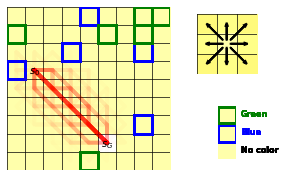

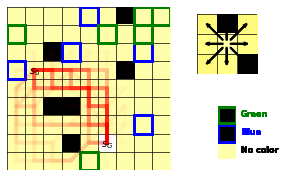

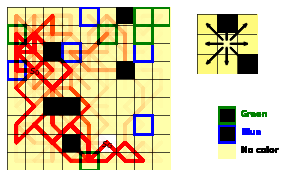

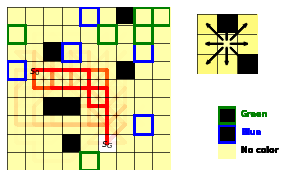

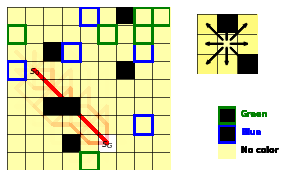

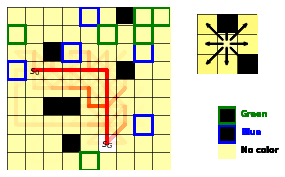

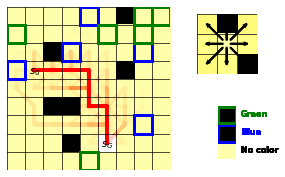

In [6]:
time_tot = int(round(time.time() * 1000))

df = pd.DataFrame()
js_div = pd.DataFrame()
mca = []

for i in range(n_trials):
    #generate constraints
    blue, green, cs, ca, start, goal = generate_constraints(9)
    #constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    '''blue = [21,  9, 59,  1,  0, 20]
    green = [42, 18, 76, 41, 23, 30]
    cs = [63, 74, 13, 39, 48, 38]
    ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
    start =7
    goal = 65'''

    constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    #generate nomminal 
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)
    temp_matrix = count_states(demo_n.trajectories, n_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='nominal')
    df = pd.concat([df, temp_dict])
    
    #generate constrained grid
    cc = [1, 2]
    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)
    temp_matrix = count_states(demo_c.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='const')
    df = pd.concat([df, temp_dict])
    
    mca_s1 = MCA(n=n, c=c, demo=demo_c, only_s1=True)
    demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1 = count_states(demo_mca_s1.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1, type_mca='s1', agent=mca_s1, s1_usage=mca_s1.getStatistics()[0])
    f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])
    
    mca_s1_nb = MCA(n=n, c=c, demo=None, only_s1=True)
    demo_mca_s1_nb = mca_s1_nb.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1_nb = count_states(demo_mca_s1_nb.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1_nb, type_mca='s1_nb', agent=mca_s1_nb, s1_usage=mca_s1_nb.getStatistics()[0])
    f1 = G.plot_world(f'Only S1', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s1_nb, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])
    
    mca_s2 = MCA(n=n, c=c, demo=None, threshold5=1, only_s2=True)
    demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s2, type_mca='s2', agent=mca_s2 )
    f1 = G.plot_world(f'Only S2', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_s2, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])
    
    '''mca_mixed = MCA(n=n, c=c, demo=demo_c, threshold5=1, mixed=True)
    demo_mca_mixed = mca_mixed.generate_trajectories(n_trajectories)
    temp_matrix_mca_mixed = count_states(demo_mca_mixed.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_mixed, type_mca='mixed', agent=mca_mixed, s1_usage=mca_mixed.getStatistics()[0])
    f1 = G.plot_world(f'Mixed', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_mixed, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    df = pd.concat([df, temp_dict])'''
    
    '''temp_jsdiv = {}
    temp_jsdiv['t3'] = 0.4
    temp_jsdiv['t4'] = 0
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_s1.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s1.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = 's1'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    js_div = pd.concat([js_div, temp_jsdiv])
    
    temp_jsdiv = {}
    temp_jsdiv['t3'] = 0.4
    temp_jsdiv['t4'] = 0
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_mixed.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_mixed.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = 'mixed'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    js_div = pd.concat([js_div, temp_jsdiv])'''
    
    temp_jsdiv = {}
    temp_jsdiv['t3'] = threshold3
    temp_jsdiv['t4'] = threshold4
    temp_jsdiv['jsdiv'] = js_divergence((mca_s2.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s2.modelSelf.ntra_per_transition + 1E-10), (mca_s1_nb.modelSelf.ntra_per_transition + 1E-10)/np.sum(mca_s1_nb.modelSelf.ntra_per_transition + 1E-10))
    temp_jsdiv['type'] = 'S1'
    temp_jsdiv = pd.DataFrame(data=temp_jsdiv, index=[0])
    js_div = pd.concat([js_div, temp_jsdiv])
    
    time_exp = int(round(time.time() * 1000))
    #df = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold1 = [10, 50, 100, 200, 300], df=df, bootstrap = bootstrap)
    #df2 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold2 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df2, bootstrap = bootstrap)
    
    #df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = 0, df = df, jsdiv=js_div, bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold1=threshold1, threshold3 = threshold3, threshold4 = threshold4, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    '''df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = 0.4, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = 0.6, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = 0.8, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = 1, df = df, jsdiv=js_div,  bootstrap = bootstrap)'''
    time_exp = int(round(time.time() * 1000)) - time_exp
    print(f"\n {i} #############################################\n")
    '''df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 0, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 0.2, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 0.4, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 0.6, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 0.8, df = df, jsdiv=js_div,  bootstrap = bootstrap)
    df, js_div = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = 1, df = df, jsdiv=js_div,  bootstrap = bootstrap)'''
    #df7 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold7 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df7, bootstrap = bootstrap)

    #print(f"Varying t1: {time_exp}")

time_tot = int(round(time.time() * 1000)) - time_tot
print(f"Total time: {time_tot}")


In [7]:

'''label='length'
list_df = [df3[label],df4[label]]
list_mean=[(np.mean(x)+np.std(x))*1.1 for x in list_df]

print(np.max(list_mean))
'''
'''def min_max(label, df, df2, df3, df4, df7):
    list_df = [df[label],df2[label],df3[label],df4[label],df7[label]]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label'''

def min_max(label, df):
    list_df = df[label]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    #print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label

In [8]:
temp_df = df.loc[(df['type']=='s1_nb')]['time'].values
#for x in temp_df:
#    print(x)

Prima
Dopo
constrained_line: 11.8465 length
nominal_line: 5.4030000000000005 length
s2: 7.1255 s1:47.0322


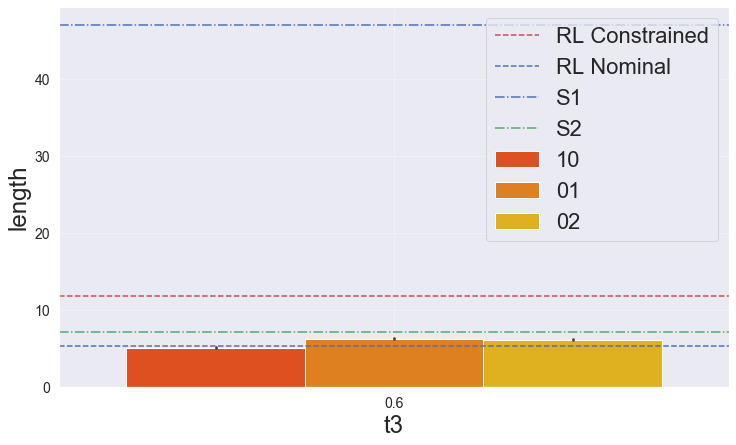

Prima
Dopo
constrained_line: -53.074422197280185 reward
nominal_line: -14.90416939374139 reward
s2: -33.565693114297744 s1:-791.9428837079844


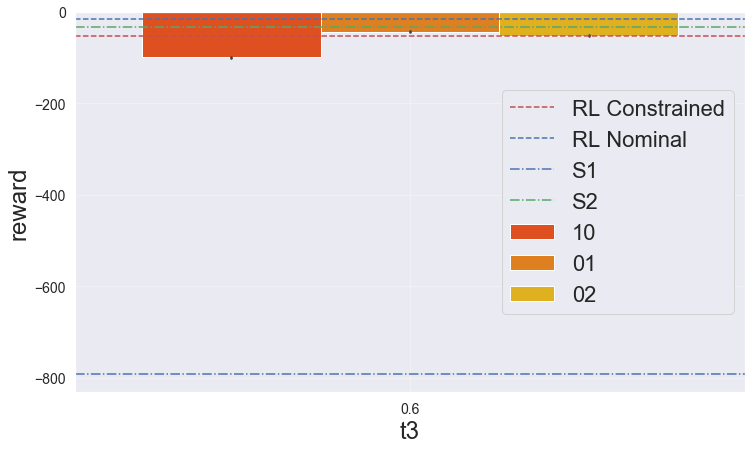

ok
Prima
Dopo
constrained_line: 0.0 time
nominal_line: 0.0 time
s2: 140.2906 s1:92.1543


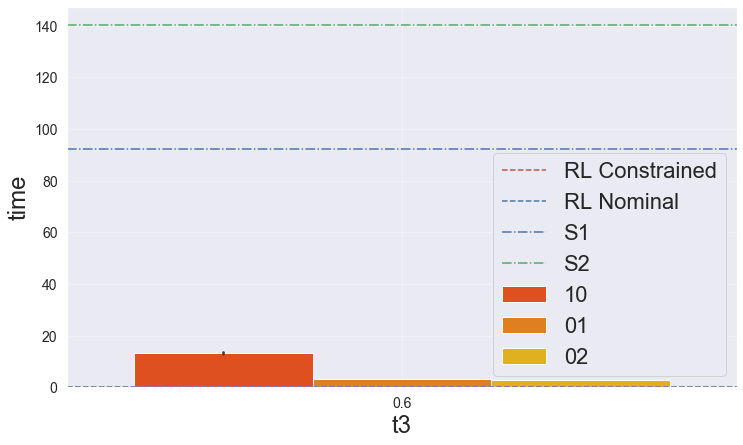

In [9]:
temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==threshold3) | (df['type']=='s1_nb') | (df['type']=='s2') | (df['type']=='nominal')| (df['type']=='const')]

#temp_df = temp_df.rename(columns={"01": "SOFAI-01", "s1": "S1-SOFAI"})

label_x = 't3'
label='length'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='reward'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='time'
min_label, max_label = min_max(label, df)
print("ok")
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

#label='S1_Usage'
#min_label, max_label = min_max(label, df, df2, df3, df4, df7)
#plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

In [10]:
'''temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==threshold3)]

label_x = 't4'
label='length'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='reward'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='time'
min_label, max_label = min_max(label, df)
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='avg_time_s1'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)'''

"temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==threshold3)]\n\nlabel_x = 't4'\nlabel='length'\nmin_label, max_label = min_max(label, df)\nplot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)\n\nlabel='reward'\nmin_label, max_label = min_max(label, df)\nplot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=max_label)\n\nlabel='time'\nmin_label, max_label = min_max(label, df)\nplot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)\n\nlabel='Viol'\nmin_label, max_label = min_max(label, df, df2, df3, df4, df7)\nplot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)\n\nlabel='S1_Usage'\nmin_label, max_label = min_max(label, df, df2, df3, df4, df7)\nplot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)\n\nlabel='avg_time_s1'\nmin_label, max_label = min_max(label, df, df2, df3, df4, df7)\nplot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)"

In [11]:
#df3.loc[(df3['type']=='02') & (df3['t3']==0.4)& (df3['t4']==0)]
temp_df

,traj_n,length,reward,time,sub_type,time_agent,avg_time,reward_agent,avg_reward,usage,...,Reward,Viol,S1_Usage,t1,t2,t3,t4,t6,t7,perc_usage
0,0,3.750,-8.247434,0,null,0,0.000000,0.000000,0.000000,0,...,-8.247434,1.520,0.000000,200,0.8,0.0,0,1,0.5,NaN
0,0,4.615,-16.301883,0,null,0,0.000000,0.000000,0.000000,0,...,-16.301883,0.045,0.000000,200,0.8,0.0,0,1,0.5,NaN
0,0,61.000,-1300.793939,4,s1,4,0.065574,-1300.793939,-21.324491,61,...,-446.204738,6.503,1.000000,200,0.8,0.0,0,1,0.5,1.0
0,0,61.000,-1300.793939,4,s2,0,NaN,0.000000,NaN,0,...,-446.204738,6.503,1.000000,200,0.8,0.0,0,1,0.5,0.0
1,1,198.000,-2405.480231,95,s1,95,0.479798,-2405.480231,-12.148890,198,...,-446.204738,6.503,1.000000,200,0.8,0.0,0,1,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,10.000,-80.000000,4,s2,0,NaN,0.000000,NaN,0,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,0.0
998,998,8.000,-22.000000,3,s1,3,0.375000,-22.000000,-2.750000,8,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,1.0
998,998,8.000,-22.000000,3,s2,0,NaN,0.000000,NaN,0,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,0.0
999,999,8.000,-22.000000,2,s1,2,0.250000,-22.000000,-2.750000,8,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,1.0


In [12]:
'''#df.loc[(df['type']=='02') & (df['t1']==200)]


df = temp_df
plt.figure(figsize=(12, 7))
plt.plot(df.loc[(df['type']=='02') & (df['t3']==0.4)& (df['t4']==0)]['usage_s1'].values, label="S1")
plt.plot(df.loc[(df['type']=='02') & (df['t3']==0.4)& (df['t4']==0)]['usage_s2'].values, label="S2")
plt.title("Percentage of time")
plt.legend()
plt.show()'''

'#df.loc[(df[\'type\']==\'02\') & (df[\'t1\']==200)]\n\n\ndf = temp_df\nplt.figure(figsize=(12, 7))\nplt.plot(df.loc[(df[\'type\']==\'02\') & (df[\'t3\']==0.4)& (df[\'t4\']==0)][\'usage_s1\'].values, label="S1")\nplt.plot(df.loc[(df[\'type\']==\'02\') & (df[\'t3\']==0.4)& (df[\'t4\']==0)][\'usage_s2\'].values, label="S2")\nplt.title("Percentage of time")\nplt.legend()\nplt.show()'

In [13]:
def print_results(df, type_agent):
    print(f"{type_agent}: -> Length: {np.mean(df['length']):6.2f} \
 ({np.mean(df.loc[(df['sub_type']=='s1')]['usage']):6.2f} ; {np.mean(df.loc[(df['sub_type']=='s2')]['usage']):6.2f}) \
 Rew: {np.mean(df['reward']):10.4f} ({np.nanmean(df.loc[(df['sub_type']=='s1')]['avg_reward']):6.2f} ; {np.nanmean(df.loc[(df['sub_type']=='s2')]['avg_reward']):6.2f}) \
 Time: {np.mean(df['time']):10.4f} ({np.mean(df.loc[(df['sub_type']=='s1')]['avg_time']):6.4f} ; {np.mean(df.loc[(df['sub_type']=='s2')]['avg_time']):6.4f})")

#df3.loc[(df3['traj_n']>=0) & (df3['t4']==0) & (df3['t3']==0.4) & (df3['type']=='const')]
temp_df = df.loc[df['type']=='const']
print_results(temp_df,'RL')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==threshold3) & (df['t4']==threshold4) & (df['type']=='10')]
print_results(temp_df,'MCA 10')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==threshold3) & (df['t4']==threshold4) & (df['type']=='01')]
print_results(temp_df,'MCA 01')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==threshold3) & (df['t4']==threshold4) & (df['type']=='02')]
print_results(temp_df,'MCA 55')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==0) & (df['t4']==0) & (df['type']=='s1')]
print_results(temp_df,'Only S1')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==0) & (df['t4']==0) & (df['type']=='s2')]
print_results(temp_df,'Only S2')
temp_df = df.loc[(df['traj_n']<bootstrap) & (df['t3']==0) & (df['t4']==0) & (df['type']=='mixed')]
print_results(temp_df,'Mix Bef')
temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==0) & (df['t4']==0) & (df['type']=='mixed')]
print_results(temp_df,'Mix Aft')


temp_df = df.loc[(df['traj_n']>=bootstrap) & (df['t3']==0.4) & (df['t4']==0) & (df['type']=='10')]
temp_df


RL: -> Length:  11.85  (   nan ;    nan)  Rew:   -53.0744 (   nan ;    nan)  Time:     0.0000 (   nan ;    nan)
MCA 10: -> Length:   5.16  (  4.58 ;   0.59)  Rew:   -99.2817 (-19.38 ;  -7.58)  Time:    13.2733 (0.3517 ; 20.1627)
MCA 01: -> Length:   6.29  (  6.25 ;   0.04)  Rew:   -43.7414 ( -5.50 ;  -4.69)  Time:     3.1763 (0.3594 ; 19.1119)
MCA 55: -> Length:   6.19  (  6.16 ;   0.04)  Rew:   -52.0764 ( -8.88 ;  -8.64)  Time:     2.7282 (0.3241 ; 19.3932)
Only S1: -> Length:   9.60  (  9.60 ;   0.00)  Rew:   -47.4615 ( -3.96 ;    nan)  Time:    14.7859 (0.8416 ;    nan)
Only S2: -> Length:   7.13  (  0.00 ;   7.13)  Rew:   -33.5657 (   nan ;  -3.95)  Time:   140.2906 (   nan ; 19.2769)
Mix Bef: -> Length:    nan  (   nan ;    nan)  Rew:        nan (   nan ;    nan)  Time:        nan (   nan ;    nan)
Mix Aft: -> Length:    nan  (   nan ;    nan)  Rew:        nan (   nan ;    nan)  Time:        nan (   nan ;    nan)


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


,traj_n,length,reward,time,sub_type,time_agent,avg_time,reward_agent,avg_reward,usage,...,Reward,Viol,S1_Usage,t1,t2,t3,t4,t6,t7,perc_usage


In [14]:
df.to_csv("dati_new_10grid_t1_100.csv")
js_div.to_csv("jsdiv_new_10grid_t1_100.csv")
#pd.read_csv("dati_new_10grid_t1_100.csv")

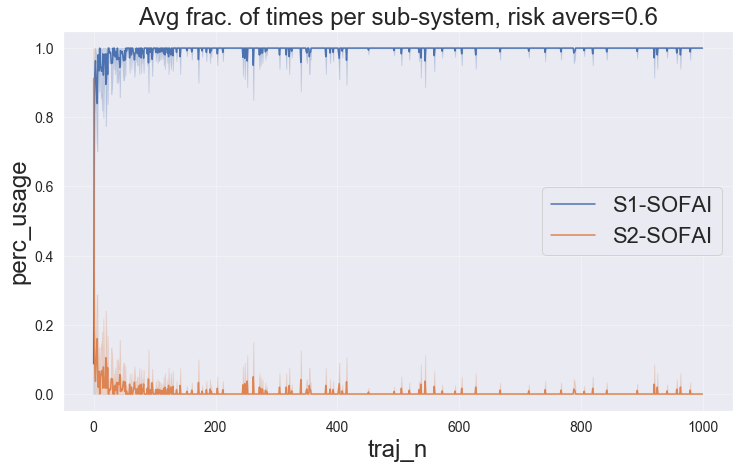

In [29]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
temp_df = df.loc[(df['traj_n']>=0) & ((df['type']=='01') )  ] #| (df['type']=='s1_nb') 

x='traj_n'
y='perc_usage'
#y='avg_reward'
#y='avg_time'


fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)#
g=sns.lineplot(x=x, y=y, data=temp_df, hue="sub_type",markers=True, dashes=False)
#g=sns.scatterplot(x=x, y=y, data=temp_df, hue="sub_type",markers=True)
#g = sns.barplot(x=x, y=y, hue="type", data=temp_df.loc[(temp_df['type']!="const")& (temp_df['type']!="s1") & (temp_df['type']!="s2")& (temp_df['traj_n']>=bootstrap)], palette="autumn", ci=95);
#g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

#constrained_line = np.median(df.loc[(df['type']=="const")][y])
#s1_line = np.median(temp_df.loc[(temp_df['type']=="s1")& (temp_df['traj_n']>=bootstrap)][y])
#s2_line = np.median(temp_df.loc[(temp_df['type']=="s2")& (temp_df['traj_n']>=bootstrap)][y])

#g.axhline(constrained_line, color='r', linestyle='--', label="RL")
#g.axhline(s1_line, color='b', linestyle='--', label="S1")

#g.axhline(s2_line, color='g', linestyle='-.', label="S2")
#g.set_ylim([0, 40])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label="Avg frac. of times per sub-system, risk avers="+str(threshold3))
#plt.title(label="Avg reward for a single move per trajectory, risk avers="+str(threshold3))
#plt.title(label="Avg time for a single move per trajectory, risk avers="+str(threshold3))

h, l = g.get_legend_handles_labels()
#labels=["S2","SOFAI 01"]
labels=["S1-SOFAI","S2-SOFAI"]
g.legend(h, labels)

#plt.legend()
plt.grid(alpha=0.3)
#g.set_xticks(range(11)) # <--- set the ticks first

#plt.xlabel("W(Nominal, Constraints)")
#plt.ylabel("Avg JS dist")
plt.savefig('avg_frac_times_risk'+str(threshold3)+'.pdf')
#plt.savefig('avg_reward_risk'+str(threshold3)+'.pdf')
#plt.savefig('avg_time_risk'+str(threshold3)+'.pdf')

plt.show()

In [ ]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s2')|  (df['type']=='01'))]
#temp_df = df.loc[(df['traj_n']>=0) & ((df['type']=='01') )  ] #| (df['type']=='s1_nb') 

x='traj_n'
#y='perc_usage'
#y='reward'
y='time'


fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)#
g=sns.lineplot(x=x, y=y, data=temp_df, hue="type",markers=True, dashes=False)
#g=sns.scatterplot(x=x, y=y, data=temp_df, hue="sub_type",markers=True)
#g = sns.barplot(x=x, y=y, hue="type", data=temp_df.loc[(temp_df['type']!="const")& (temp_df['type']!="s1") & (temp_df['type']!="s2")& (temp_df['traj_n']>=bootstrap)], palette="autumn", ci=95);
#g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

#constrained_line = np.median(df.loc[(df['type']=="const")][y])
#s1_line = np.median(temp_df.loc[(temp_df['type']=="s1")& (temp_df['traj_n']>=bootstrap)][y])
#s2_line = np.median(temp_df.loc[(temp_df['type']=="s2")& (temp_df['traj_n']>=bootstrap)][y])

#g.axhline(constrained_line, color='r', linestyle='--', label="RL")
#g.axhline(s1_line, color='b', linestyle='--', label="S1")

#g.axhline(s2_line, color='g', linestyle='-.', label="S2")#
#g.set_ylim([0, 400])
#g.set_ylim([-100, 0])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title(label="Avg fraction of times each sub-system is used w=[0,1]")
#plt.title(label="Avg reward for a single move per trajectory w=[0,1]")
#plt.title(label="Avg reward per trajectory w=[0,1]")


h, l = g.get_legend_handles_labels()
labels=["S2","SOFAI 01"]
#labels=["S1","S2"]
g.legend(h, labels)

#plt.legend()
plt.grid(alpha=0.3)
#g.set_xticks(range(11)) # <--- set the ticks first

#plt.xlabel("W(Nominal, Constraints)")
#plt.ylabel("Avg JS dist")
#plt.savefig('avg_reward'+str(threshold3)+'.pdf')
plt.savefig('avg_time'+str(threshold3)+'.pdf')
plt.show()

In [17]:
df.loc[(df['traj_n']>=0) & ((df['type']=='nominal') )  ]
y='length'
np.mean(df.loc[(df['type']=="nominal")][y])

5.4030000000000005

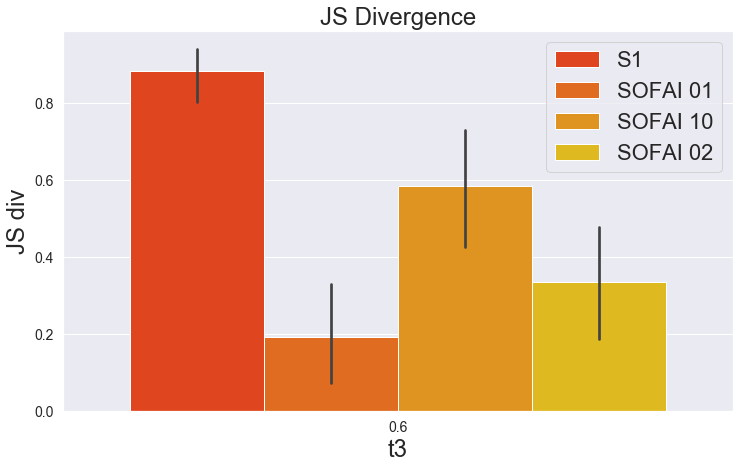

In [21]:
temp_df = js_div.loc[((js_div['t3']==threshold3) & (js_div['t4']==threshold4)) | (js_div['type']=='s1_nb')]

y='jsdiv'


fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
#g=sns.relplot(x="i", y=[i[0] for i in df['avg_js_dist']],  kind="line", data=df, palette="Greens", height=7, aspect=2);
#g=sns.lineplot(x="t4", y='jsdiv', data=temp_df, hue="type",markers=True, dashes=False)
g = sns.barplot(x='t3', y=y, hue="type", data=temp_df, palette="autumn", ci=95);
#g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

h, l = g.get_legend_handles_labels()
labels=['S1',"SOFAI 01","SOFAI 10","SOFAI 02"]
g.legend(h, labels)

#g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

#mixed_line = js_div.loc[js_div['type']=='mixed']['jsdiv'].values
#g.axhline(mixed_line, color='r', linestyle='--', label="Mixed")

#mixed_line = js_div.loc[js_div['type']=='s1_nb']['jsdiv'].values
#g.axhline(mixed_line, color='b', linestyle='--', label="S1_NB")

#plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#g.set_xticks(range(11)) # <--- set the ticks first

plt.xlabel("t3")
plt.ylabel("JS div")
plt.title("JS Divergence")
plt.show()
fig.savefig(f"avg_js_dist"+str(threshold3)+".pdf", bbox_inches = 'tight') 

In [19]:
df

,traj_n,length,reward,time,sub_type,time_agent,avg_time,reward_agent,avg_reward,usage,...,Reward,Viol,S1_Usage,t1,t2,t3,t4,t6,t7,perc_usage
0,0,3.750,-8.247434,0,null,0,0.000000,0.000000,0.000000,0,...,-8.247434,1.520,0.000000,200,0.8,0.0,0,1,0.5,NaN
0,0,4.615,-16.301883,0,null,0,0.000000,0.000000,0.000000,0,...,-16.301883,0.045,0.000000,200,0.8,0.0,0,1,0.5,NaN
0,0,6.000,-22.284271,4,s1,4,0.666667,-22.284271,-3.714045,6,...,-16.362923,0.055,1.000000,200,0.8,0.0,0,1,0.5,1.0
0,0,6.000,-22.284271,4,s2,0,NaN,0.000000,NaN,0,...,-16.362923,0.055,1.000000,200,0.8,0.0,0,1,0.5,0.0
1,1,4.000,-10.970563,3,s1,3,0.750000,-10.970563,-2.742641,4,...,-16.362923,0.055,1.000000,200,0.8,0.0,0,1,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997,10.000,-80.000000,4,s2,0,NaN,0.000000,NaN,0,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,0.0
998,998,8.000,-22.000000,3,s1,3,0.375000,-22.000000,-2.750000,8,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,1.0
998,998,8.000,-22.000000,3,s2,0,NaN,0.000000,NaN,0,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,0.0
999,999,8.000,-22.000000,2,s1,2,0.250000,-22.000000,-2.750000,8,...,-33.983009,0.162,0.995019,200,0.8,0.6,200,1,0.5,1.0
